In [ ]:
import os, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}, Seed: {SEED}")


[INFO] Using device: cuda, Seed: 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_DIR = "/content/drive/MyDrive"

X = np.load(os.path.join(DRIVE_DIR, "DREAMERV_X.npy"), allow_pickle=True)
y = np.load(os.path.join(DRIVE_DIR, "DREAMERV_y.npy"), allow_pickle=True)
print(f"[INFO] Loaded X={X.shape}, y={y.shape}, labels={np.unique(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print(f"[INFO] Train={len(X_train)}, Test={len(X_test)}")


[INFO] Loaded X=(170246, 14, 256), y=(170246,), labels=[0 1]
[INFO] Train=136196, Test=34050


In [ ]:
def normalize_data(X):
    # Per-sample, per-channel normalization across time axis
    mean = np.mean(X, axis=2, keepdims=True)
    std = np.std(X, axis=2, keepdims=True)
    std[std == 0] = 1
    return (X - mean) / std

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
print("[INFO] Normalization applied (per sample, per channel).")


[INFO] Normalization applied (per sample, per channel).


In [ ]:
class EvalSet(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.int64)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

test_loader = DataLoader(EvalSet(X_test, y_test), batch_size=64, shuffle=False)


In [ ]:
class EEG_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(14, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):  # expects [B, 14, T]
        x = self.conv1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

ckpt = os.path.join(DRIVE_DIR, "cnn_model.pth")
model = EEG_CNN(num_classes=2).to(DEVICE)
model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
model.eval()
print(f"[INFO] Loaded checkpoint: {ckpt}")


[INFO] Loaded checkpoint: /content/drive/MyDrive/cnn_model.pth


/tmp/ipython-input-4079344158.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xb = torch.tensor(Xb, dtype=torch.float32, device=DEVICE)


[RESULT] Accuracy: 0.8115
[RESULT] Macro F1: 0.8018

Classification Report:
               precision    recall  f1-score   support

           0     0.8166    0.8769    0.8457     20054
           1     0.8028    0.7178    0.7579     13996

    accuracy                         0.8115     34050
   macro avg     0.8097    0.7974    0.8018     34050
weighted avg     0.8109    0.8115    0.8096     34050



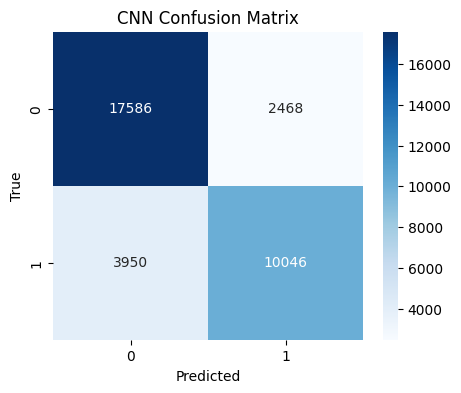

In [ ]:
y_true, y_pred = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = torch.tensor(Xb, dtype=torch.float32, device=DEVICE)

        yb = yb.to(DEVICE)

        preds = torch.argmax(model(Xb), dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
print(f"[RESULT] Accuracy: {acc:.4f}")
print(f"[RESULT] Macro F1: {f1m:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("CNN Confusion Matrix")
plt.show()


In [ ]:
#  CNN Stability Check
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score

def eval_loader(model, loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device=DEVICE, dtype=torch.float32)
            yb = yb.to(DEVICE)
            preds = torch.argmax(model(xb), dim=1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# --- 1) Bootstrap resampling on test set ---
yt_all, yp_all = eval_loader(model, test_loader)
B = 100  # number of bootstrap samples
accs, f1s = [], []
for _ in range(B):
    idx = np.random.randint(0, len(yt_all), len(yt_all))
    accs.append(accuracy_score(yt_all[idx], yp_all[idx]))
    f1s.append(f1_score(yt_all[idx], yp_all[idx], average="macro"))

print(f"[Bootstrap] Acc={np.mean(accs):.4f} ±{np.std(accs):.4f}")
print(f"[Bootstrap] F1 ={np.mean(f1s):.4f} ±{np.std(f1s):.4f}")

# --- 2) Stratified sub-sampling (different splits of test set) ---
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=42)
for i, (idx_keep, _) in enumerate(sss.split(X_test, y_test), 1):
    sub_loader = DataLoader(EvalSet(X_test[idx_keep], y_test[idx_keep]), batch_size=64, shuffle=False)
    yt_sub, yp_sub = eval_loader(model, sub_loader)
    print(f"[Split {i}] Acc={accuracy_score(yt_sub, yp_sub):.4f}, F1={f1_score(yt_sub, yp_sub, average='macro'):.4f}")


[Bootstrap] Acc=0.8112 ±0.0022
[Bootstrap] F1 =0.8015 ±0.0023
[Split 1] Acc=0.8113, F1=0.8018
[Split 2] Acc=0.8116, F1=0.8021
[Split 3] Acc=0.8117, F1=0.8020
